# Step 0 : Code up the Q-learning algorithm in Python

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

#import tensorflow as tf
#from tensorflow.keras.losses import MSE

import matplotlib.pypvlot as plt

PATH = 'C:\\Users\\jafouche\\Documents\\Edge_computing\\output_j08m12a22\\'

In [ ]:
# This function grabs a bottom portion of the data from the output dump file

def get_data_stream(PATH, numOFlines2grab=3000):
    
    filepath = PATH + 'Xmatrix_' + nw +  '_' + m + '.txt'
    
    # Load data
    df = pd.read_csv(filepath, sep=",", header=None)
    
    # Way 0: Rapid (last column is y_actual)
    # r, c = df.shape
    # X = df.iloc[:,0:c-2].to_numpy()
    # y = df.iloc[:,c-1].to_numpy()
    
    

    # Way 2: You need all the data from all the networks
    df = pd.DataFrame()
    m = 'classification'
    
    for nw in network:
        filepath = PATH + 'Xmatrix_' + nw +  '_' + m + '.txt'

        temp = pd.read_csv(filepath, sep=",", header=None)

        # print('nw: ', nw, 'm: ', m)
        titre = nw+'_'+m
        if nw == 'edge':
            txtvec = ['NumOffloadedTask', "TaskLength","WLANUploadDelay","WLANDownloadDelay","AvgEdgeUtilization", 'y_actual']
        elif nw == 'rsu':
            txtvec = ["NumOffloadedTask","WANUploadDelay","WANDownloadDelay", 'y_actual']
        elif nw == 'gsm':
            txtvec = ["NumOffloadedTask","GSMUploadDelay","GSMDownloadDelay", 'y_actual']

        temp.columns = [nw+'_'+i for i in txtvec]
        df = pd.concat([df, temp], axis=1)
    
    X = df.take([0,1,2,3,4,6,7,8,10,11,12], axis=1)
    y = df.take([5], axis=1) # binary prediction (paper): only take y_actual for EDGE (because we only care about EDGE=0, or NON-EDGE=1)
    # Next step
    # y = df.take([5,9,13], axis=1) # categorical prediction (my suggestion):
    
    # Specify how many rows to take: takes the last numOFlines2grab number of rows from file
    X = X.iloc[-numOFlines2grab::,:].to_numpy()
    y = y.iloc[-numOFlines2grab::,:].to_numpy()

    return X, y

In [ ]:
def execute_action(action):
    
    # action = ['fail'=0, 'success'=1]
    
    # Senario 0:
    # So, how do you command the q-network with respect to this output??
    #'fail' = give the task to non-edge network (need to figure out how to do this in Java sim)
    # 'success' = give the task to gsm or rsu randomly
    
    # ****** COMMAND JAVA sim to do edge or not gsm/rsu
    
    # Then you re-collect data after the action/command : state (variables we collected) and 
    X, y = get_data_stream(PATH, numOFlines2grab=10)
    
    val = np.random.randint(low=0, high=len(X)-1, size=1)[0]
    state_after_update = X[val:val+1]
    result_of_task = y[val]   # ['fail', 'success']
    
    return result_of_task, state_after_update

In [ ]:
def determine_if_done(state):
    
    print('state:', state)
    
    if state[0][0] <= 0:
        bool_val = 1  # No resources, stop episode
    else:
        bool_val = 0
    
    return bool_val  # 0=not done, 1=done

In [ ]:
def predit_action_AND_rewards(model, X_testrowORstate, epsilon, Tall, Eall):
    
    print('X_testrowORstate.shape', X_testrowORstate.shape)
    
    # --------------------
    # Calculate the action to take, based on the weights and states
    # --------------------
    # "with probability epsilon select a random action a; otherwise select a = argmax Q(s,a, theta)"

    # step 0: predict action based on state
    # action_probablities = model.predict(X_testrowORstate)
    action_probablities = model.predict_proba(X_testrowORstate)
    print('action_probablities: ', action_probablities)
    # https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/"
    # step 1: based on the predicted action, what action should the agent take to get the maximal reward
    # Way 0: Multi-Armed Bandit Problem is the mathematical formulation of decision making during uncertainty.
    # The goal of this problem is to determine how to receive the maximum rewards for chosen actions.
    # Action-Value and Action-Value Estimate = a calculation that shows which action yields the maximum reward; the
    # agent can not know what reward they will receive for an action so the an average is taken
    # acton_value_estimate = (sum_of_rewards when action a taken before time t)/(number of times action a taken before time t)

    # If EPSILON is small it does explotation, and if EPSILON is big it does  exploration
    p = np.random.rand()
    if p < epsilon:
        action = np.random.randint(low=0, high=X_testrowORstate.shape[1]-1, size=1) # with probablity epsilon
        # OU
        # action = np.random.choice(len(state)-1)
    else:
        if any(actions):
            # Way 0: Do you use the CURRENT prediction?
            # action = np.argmax(action_probablities) # for one prediction
            # OU
            # Way 1: Do you use the mean of all past action predictions?
            # action = np.round(np.mean(actions)) # with probablity 1-epsilon
            # OU 
            # Way 2: Do you use the past mean action predictions with the CURRENT prediction??
            action = np.argmax(action_probablities, axis=1)
            actions1 = np.concatenate((actions, np.array([action])), axis=0)
            action = np.round(np.mean(actions1)) # with probablity 1-epsilon

        else:
            action = np.argmax(action_probablities, axis=1) # for one prediction
    print('action: ', action)
    # --------------------


    # --------------------
    # Perform the action: and remeasure the state, measure the result of the action
    # --------------------
    # "Execute task offloading action a in emulator"
    # This means that you change the system with the action, and re-measure the state values.
    # You also measure if the system could perform the action ---> result_of_task = ['lose', 'accomplished', 'timeout']
    result_of_task, state_after_update = execute_action(action) # need to command and measure the result (Java)
    print('result_of_task: ', result_of_task)
    print('state_after_update: ', state_after_update)
    
    # "Collect the state s_h+1 through global view after the action is performed"
    # It wants to know where the input values moved to ---> this step is state_after_update
    # --------------------


    # --------------------
    # Calculate the reward for performing the action
    # --------------------
    # "Calculate the reward R according to the input task model and the definition of the reward equation"
    
    # Need to look for equivalent in JAVA SIM (comple)
    
    if result_of_task == 0: #'lose':
        R = 0
        y_actual = 0  # 'fail'
    elif result_of_task == 1: #'accomplished':
        #R = 1/Tall + 1/Eall # parameters from paper2
        R = QoE # parameters from paper1
        y_actual = 1  # 'success'
    elif result_of_task == 0: #'timeout':
        R = -1
        # If the service time exceeds twice the expected value, the QoE value is set to 0. # parameters from paper2
        y_actual = 0  # 'fail'
    # --------------------
    
    
    # --------------------
    # For the newly measured state, are their remaining resources? yes=not done=0, no=done=1
    # --------------------
    done = determine_if_done(state_after_update)
    # --------------------
    
    return R, action, y_actual, state_after_update, done

In [17]:
def compute_loss(states, actions, rewards, done_vals, GAMMA, EPSILON, NU, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      states: an array of an array
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    
    
    # Calculate rewards for the PREVIOUS target_q_network
    # --------------------
    remaining_resources = states[-1][0]  # this is the remaining_resource variable of the last_state
    # OR
    # if done_vals[-1] == 1: # No resources, stop episode
    if remaining_resources <= 0: # No resources, stop episode
        # "Calculate Q_target^u (s_t, a_t, theta') = R_t, if s_t+1 is terminal" 
        Q_target = rewards  # R_t
        y_target = rewards

    else: # Resources available, continue
        # "or R_t + gamma*Q_target^u (s_t+1, a_t, theta') otherwise"
        
        which_way = 1
        if which_way == 0:
            # Way 0: what I thought.. Do you retrain the target_q_network with the last states, and then predict ?
            # Calculate q_target_network from the last b values : --> is this what you train the model on??
            # target_q_network.fit(states, y_t, epochs=10)
            Q_target = []
            y_target = []
            for ind, ss in enumerate(states):
                R, action, y_actual, state_after_update, done = predit_action_AND_rewards(target_q_network, 
                                                                                          ss, EPSILON, Tall, Eall)
                Q_target.append(R)
                y_target.append(rewards[ind] + GAMMA*Q_target)
                
        elif which_way == 1:
            # Way 1: class method
            # --------------------
            # Compute max Q^(s,a)
            # Tensorflow
            # max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1).numpy
            # OU
            # Sci-kit learn
            max_qsa = np.max(target_q_network.predict(states), axis=0)
            # --------------------
            
            # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a)
            # y_targets = [rewards[i] if v == 1 else rewards[i] + gamma*max_qsa[i] for i, v in enumerate(done_vals)]

            def list_comp(i):
                #return rewards[i] if done_vals[i] == 1 else rewards[i] + GAMMA*max_qsa[i] # this repeats the if statement
                return rewards[i] + GAMMA*max_qsa[i]

            y_targets = map(lambda i: list_comp(i), np.arange(len(done_vals)))
            # print('y_targets: ', y_targets)
            # --------------------
    
    
    
    # Calculate rewards for the CURRENT Q-network
    which_way = 1
    if which_way == 0:
        # Way 0: what I did - this maps probablity_predictions to actions AND rewards
        q_values = []
        for ind, ss in enumerate(states):
            R, action, y_actual, state_after_update, done = predit_action_AND_rewards(q_network, 
                                                                              ss, 
                                                                              EPSILON, Tall, Eall)
        q_values.append(R)
        
    elif which_way == 1:
        # Way 1: class method : he maps probablity_predictions to actions, not rewards
        # --------------------
        # Get the q_values
        # q_values = q_network(states)
        # OU
        q_values = q_network.predict(states)
        # --------------------

        # maps probablity_predictions to actions only
        # q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]), tf.cast(actions, tf.int32)], axis=1))
        q_values = np.argmax(q_values, axis=1)
    
    
    # --------------------
    # Compute the loss
    # "Calculate the absolute error w_t= abs(Q_target^u (s_t,a_t,theta') - Q^u (s_t,a_t,theta))"
    w_t = np.abs( y_targets - q_values )

    # "Calculate the loss function"
    loss = np.sum(w_t^2)/len(w_t)
    # --------------------
    
    # --------------------
    # "Calculate the priority of this round P_t = (np.abs(w_t)+epsilon)^nu/np.sum(np.abs(w)+epsilon)^nu"
    P_t = ((np.abs(w_t)+EPSILON)^NU)/(np.sum(np.abs(w_t)+EPSILON)^NU)
    
    # --------------------
    
    return loss, P_t

In [ ]:
# ***** This is Main program *****

# EPSILON = 1.0     # initial ε value for ε-greedy policy
EPSILON = 0.5  
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NU = 0.1

# this is measured
Tall = 1.4
Eall = 10

# -----------------------------------

# [Step 0] Make X, y matricies  - Get data from simulation 
X, y = get_data_stream(PATH, 'gsm', 'classification') # use default numOFlines2grab=3000
print('X.shape: ', X.shape)
print('y.shape: ', y.shape)

seed = 0
state_train, state_test, y_train, y_test = train_test_split(X, y, random_state = seed)
print('state_train.shape: ', state_train.shape)
print('y_train.shape: ', y_train.shape)
print('state_test.shape: ', state_test.shape)
print('y_test.shape: ', y_test.shape)

state_size = (state_train.shape[1], )
print('state_size: ', state_size)
num_actions = 3
# -----------------------------------


# -----------------------------------
# You can only do as many simulation, as you have test data
E = len(state_test)
# -----------------------------------

# -----------------------------------
# [Step 1] Create and Train the initial agent model/Q-Network model with training data

# Sci-kit learn
hL0 = 64
hL1 = 64
w_int = np.random.permutation(hL0)[0]     # Random initialization
q_network = MLPClassifier(solver='adam', activation='relu', learning_rate_init=ALPHA, 
                          hidden_layer_sizes=(hL0, hL1), random_state=w_int, max_iter=100)
# Train q_network on the train data because we will need to predict the action below
scaler = StandardScaler()
scaler.fit(state_train)  
state_train = scaler.transform(state_train)  
# Y_train_bin, unique_classes = binarize_Y1Dvec_2_Ybin(y_train) # Need to binarize Y into size [n_samples, n_classes]
# q_network.fit(state_train, Y_train_bin)
q_network.fit(state_train, y_train)

# Tensorflow
# q_network = tf.keras.Sequential([
#     tf.keras.layers.Dense(units=64, activation='relu', input_shape=state_size),
#     tf.keras.layers.Dense(units=64, activation='relu'),
#     tf.keras.layers.Dense(units=num_actions)])
# opt = tf.keras.optimizers.Adam(learning_rate=ALPHA)
# q_network.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# q_network.fit(state_train, Y_train_bin, epochs=10)
# -----------------------------------


# -----------------------------------
# [Step 2] Create the target Q^-Network - it is a model that holds a past version of Q-Network

# Sci-kit learn
# copy-paste the entire q_network: no way to input layers/weights for the neural network

# Tensorflow
# target_q_network = tf.keras.Sequential([
#     tf.keras.layers.Dense(units=64, activation='relu', input_shape=state_size),
#     tf.keras.layers.Dense(units=64, activation='relu'),
#     tf.keras.layers.Dense(units=num_actions)])
# opt = tf.keras.optimizers.Adam(learning_rate=ALPHA)
# target_q_network.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set the target network weights equal to the Q-Network weights
# target_q_network.set_weights(q_network.get_weights())

# No need to train here - we will train the model on the b experiences 
# -----------------------------------

# -----------------------------------
# How often you measure the network, to see if your action was good or bad
T = np.linspace(0, 100, num=1000, endpoint=True)
# -----------------------------------

# -----------------------------------
# [Step 3] Start each episode (rows of output simulation data to initialize the Q-learning model)
total_points_across_episodes = []

E, cc = state_test.shape

for episode in range(E): # E is each state in in the test dataset because each state in the test dataset 
    # is a potential initial state; the network can start at any of these state values because we measured it
    
    actions = []
    states = []
    rewards = []
    y_step = []
    done_vals = []
    
    # Instead of iterating over the state, read in state as a vector
    # for h in H: # H is the state vector
    
    # --------------------
    # Get initial state
    # --------------------
    state = state_test[episode:episode+1,:]
    states.append(state)
    # --------------------
    
    total_points = 0
    
    for u, t in enumerate(T): # T is the time vector
        
        R, action, y_actual, state_after_update, done = predit_action_AND_rewards(q_network, state, EPSILON, Tall, Eall)
        
        # --------------------
        # "Store transition (s_h, a_h, R_h, s_h+1, P_h) in experience replay buffer, where P_h = P"
        actions.append(action)
        states.append(state_after_update)
        rewards.append(R)
        y_step.append(y_actual)
        done_vals.append(done)
        # --------------------
        
        # --------------------
        # OK, they say not to update the weights all the time, you update the weights periodically
        #if t == u:  # this depends on the interval of T, and appears to be rare
        if t % 10 == 0:   # let's try every 10 data points we update the weights
            
            # what is the goal?  to change the weights of the NN so that for the same type of input/state values, 
            # it outputs the most optimal actions - is like GANS 
            
            # "Extract b experiences  on priority from the experience replay buffer"
            # let's take the last 10 calculated actions, states, and rewards
            a_t = actions[-10::]
            s_t = states[-10::]
            R_t = rewards[-10::]
            y_t = y_step[-10::]
            d_t = done_vals[-10::]
            
            
            if which_ml_program == 'tensorflow':
                # This calls compute_loss and then updates the gradients of q_network w/Gradient Tape using the loss 
                # that we calculated using the previous version of the model(target_q_network)
                P_t, q_network = agent_learn_tensorflow(s_t, a_t, R_t, d_t, GAMMA, EPSILON, NU, q_network, target_q_network)
                
            elif which_ml_program == 'scikit_learn':
                loss, P_t = compute_loss(s_t, a_t, R_t, d_t, GAMMA, q_network, target_q_network)
                
                # Need to update q_network: with the found loss using the error between target_q_network and q_network
                #q_network = ?? # how do you do when you can't access the weights??
                # Will look..for now
                q_network = q_network
                
        # -------------------- 
        
        # --------------------
        # Update the state for the for loop
        state = state_after_update
        # --------------------
        
        # --------------------
        # Keep track of the total reward
        total_points += R
        # --------------------
        
        # --------------------
        if done:
            break
        # --------------------
        
        # --------------------
        
    total_points_across_episodes.append(total_points)
    
    # Update the ε value
    # If EPSILON is small it does explotation, and if EPSILON is big it does  exploration
    performance_cur = total_points_across_episodes[-1]/(episode)
    performance_prev = total_points_across_episodes[-2]/(episode-1)
    if (performance_cur - performance_prev) < 0:
        # decreasing performance - make epsilon smaller so it selects from model output more
        EPSILON = EPSILON - 0.05
    print('EPSILON: ', EPSILON)

In [ ]:
@tf.function
def agent_learn_tensorflow(states, actions, rewards, done_vals, GAMMA, EPSILON, NU, q_network, target_q_network):
    """
    Updates the weights of the Q networks.
    
    Args:
      gamma: (float) The discount factor.
    
    """
    
    # --------------------
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss, P_t = compute_loss(states, actions, rewards, done_vals, GAMMA, EPSILON, NU, q_network, target_q_network)

    # --------------------
    
    
    # --------------------
    # "Update model parameter theta = theta - alpha*gradient_theta L(theta)"
    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
    # --------------------
    
    return P_t, q_network

# Step 1: Get the data from the simulation program

Use the same features that were used in Sonmez et al. Launch Java simulation program and collect data to TRAIN the model for predicting which network to use (EDGE, GSM, RSU)

0) Paper : they use C:\\Users\\jafouche\\Documents\\Edge_computing\\EdgeCloudSim_master\\scripts\\sample_app5\\ai_trainer\\data_converter.py to create the X_matrix 
1) Q_learning : Added write to file code in WekaWrapper2.java to save the network variables to an X_matrix file for each network. Import X_matrix files and just read the last line for new sample points.



## Plot data: Exploratory Data Analysis (EDA) - identify which features are useful

In [2]:
def plot_features(df, titre):
    r, c = df.shape
    rows = int(np.floor(np.sqrt(c))) # rows will always be filled
    cols = c - rows # cols will be short

    # it must be minimumn (2,2) : silly matplotlib funtionality
    if rows < 2:
        rows = 2
    if cols < 2:
        cols = 2  

    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    cnt = 0 
    title = df.columns.to_numpy()
    for rr in range(rows):
        for cc in range(cols):
            
            if cnt < c:
                if title[cnt] == 'y_actual':
                    y_actual_bool = [1 if i == 'success' else 0 for i in df['y_actual']]
                    axs[rr, cc].plot(y_actual_bool)
                else:
                    axs[rr, cc].plot(df.iloc[:,cnt])

                axs[rr, cc].set_title(titre+title[cnt])
                cnt = cnt + 1
            
    return

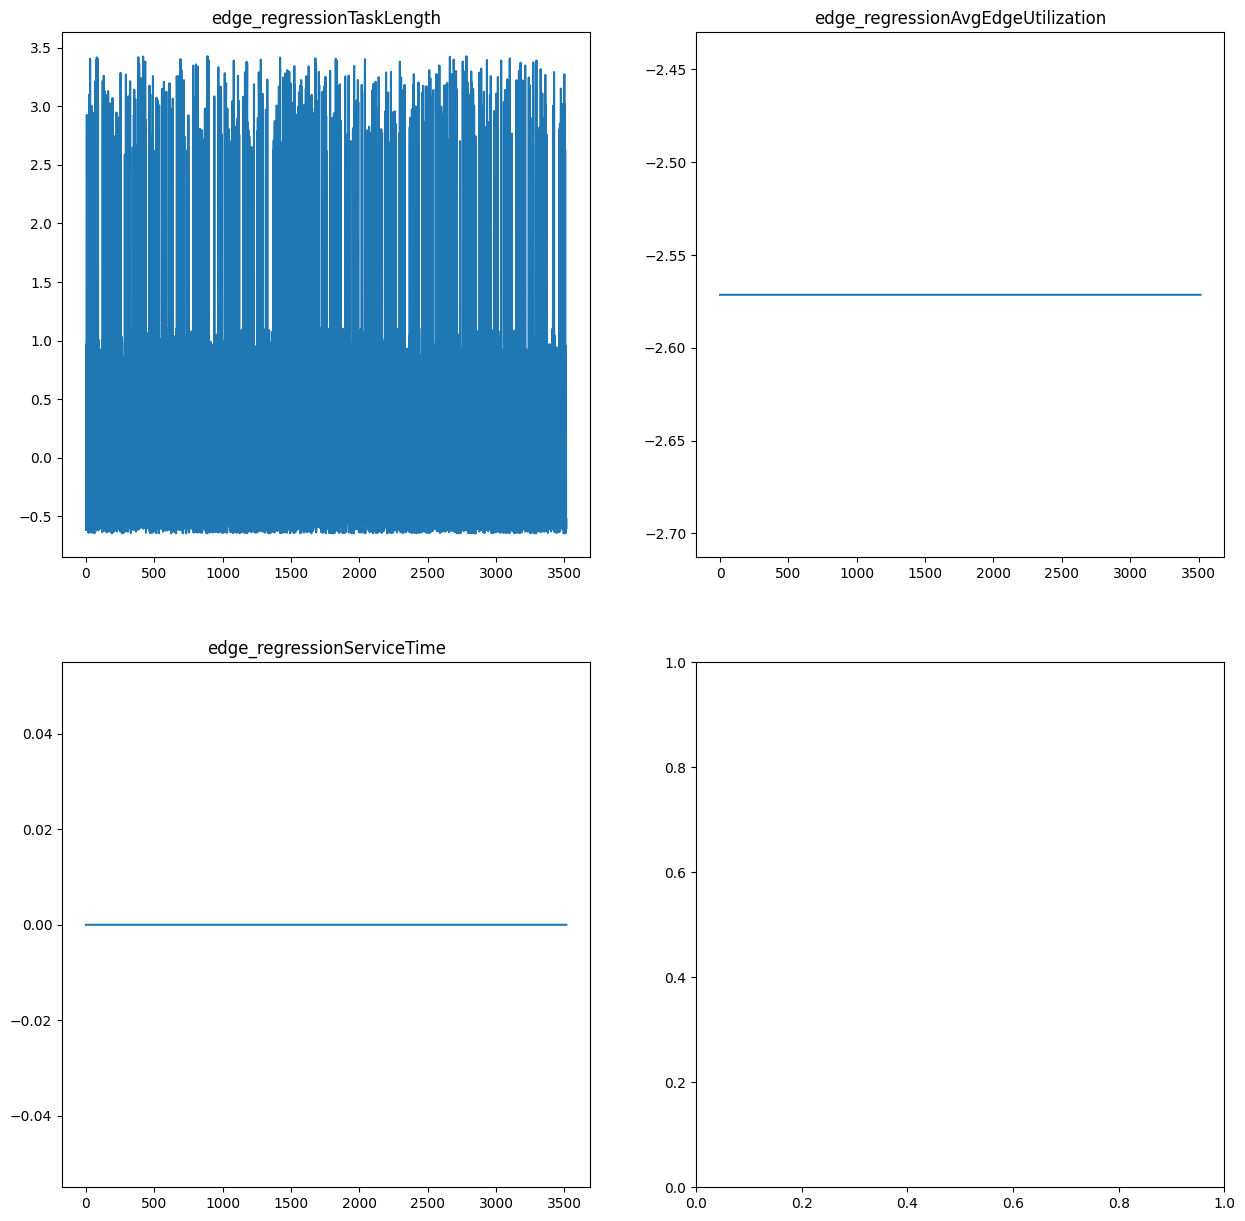

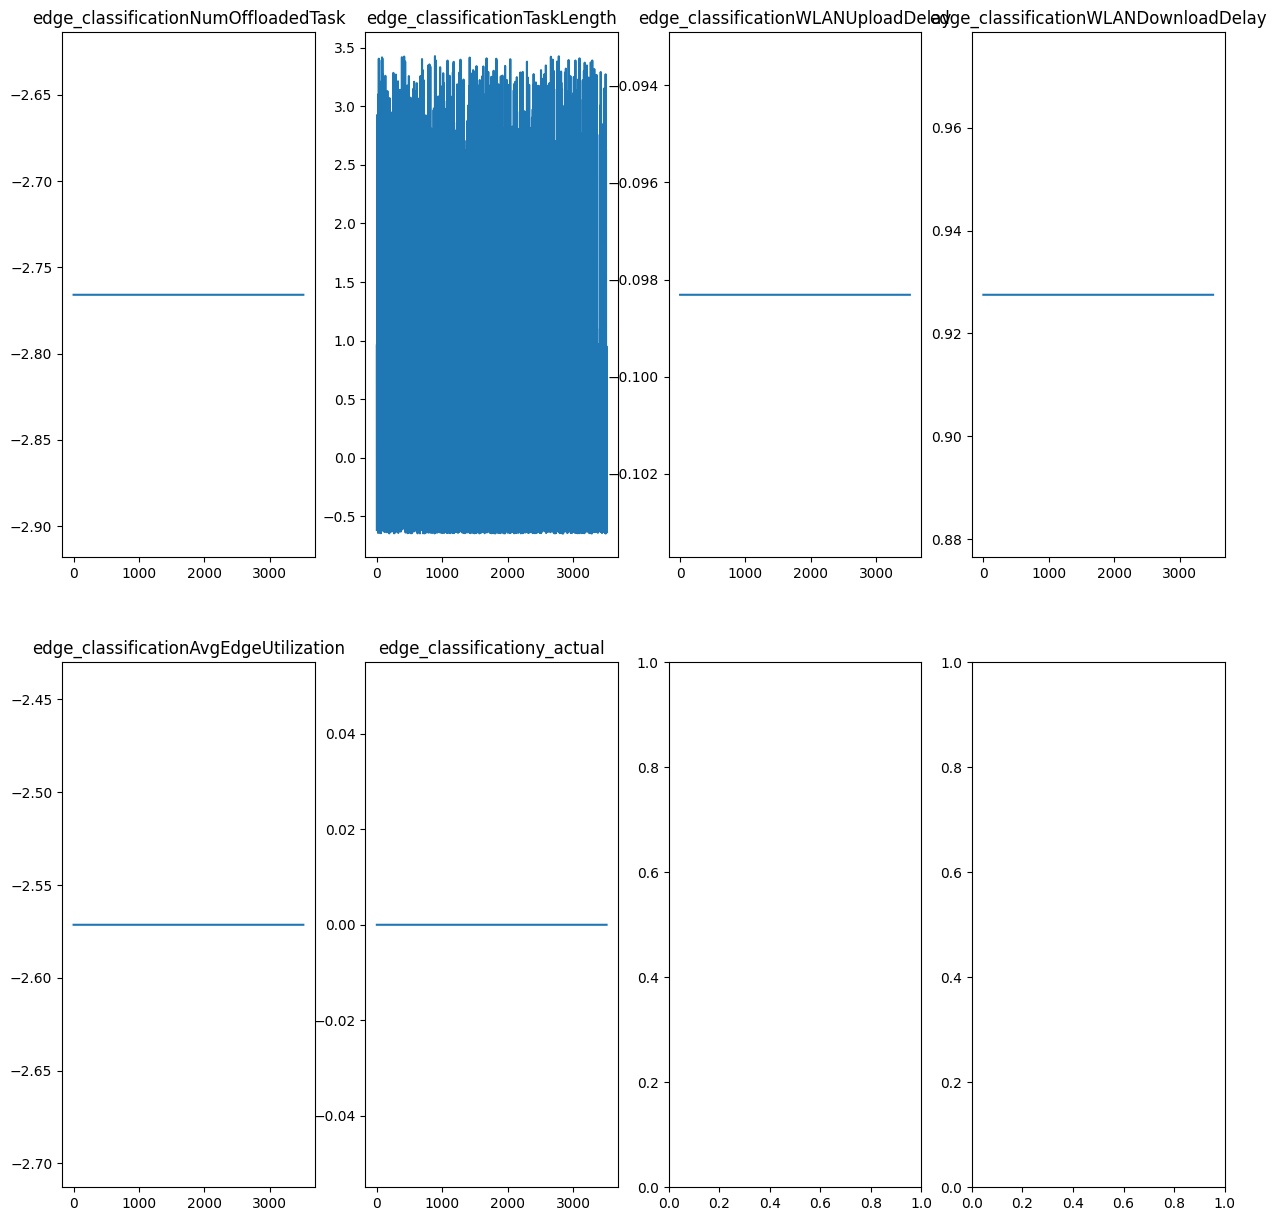

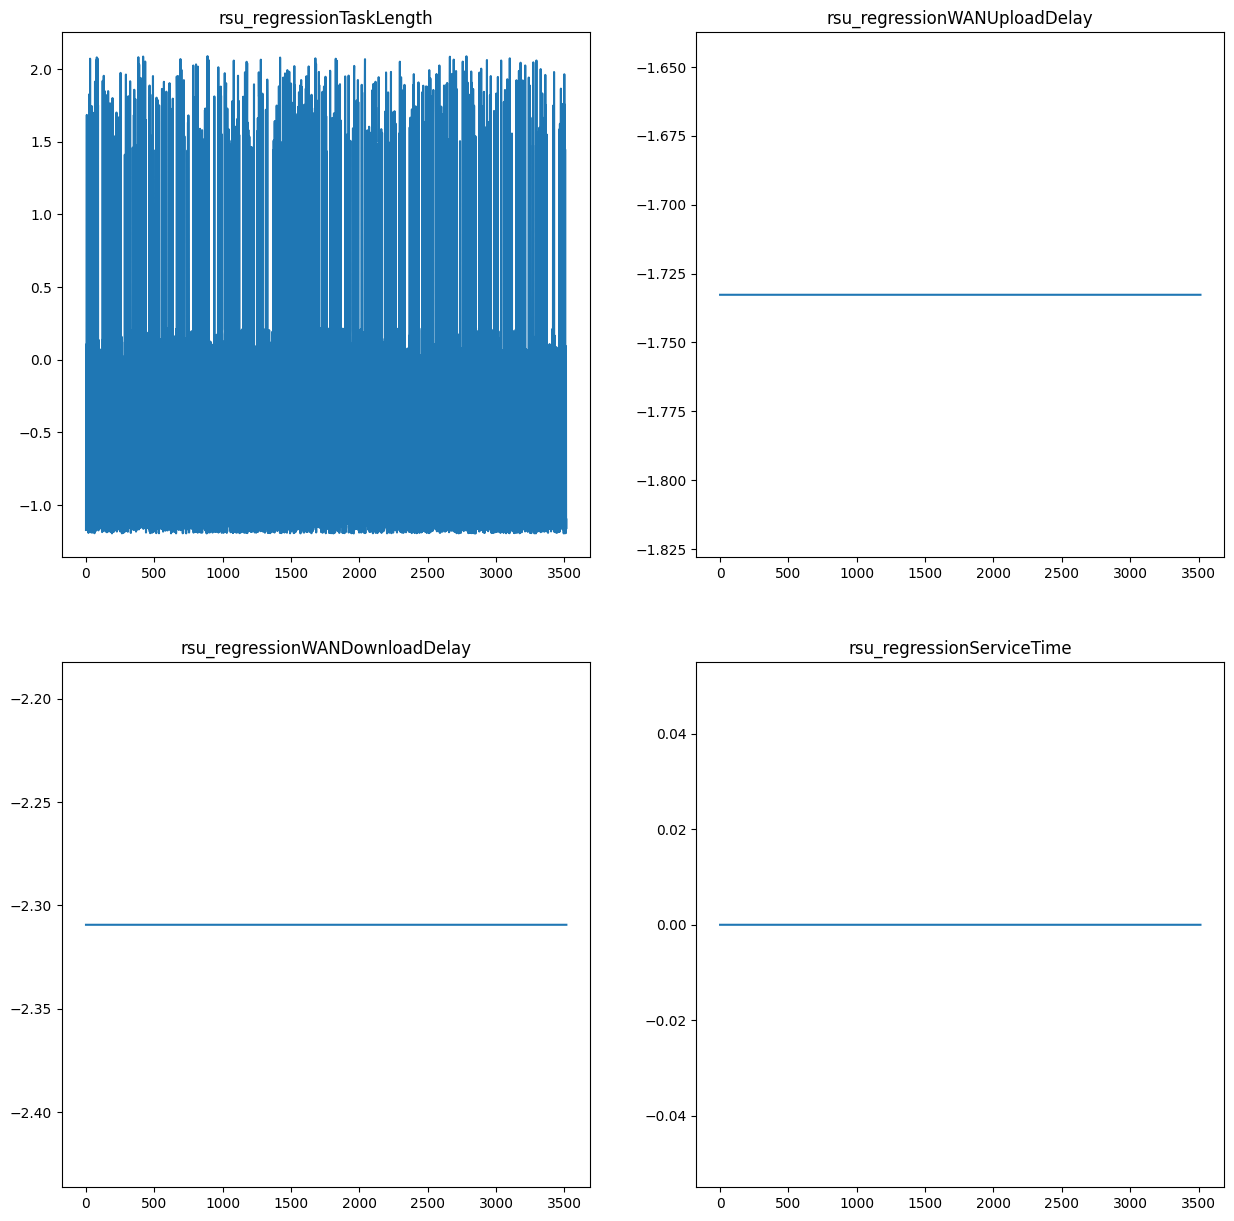

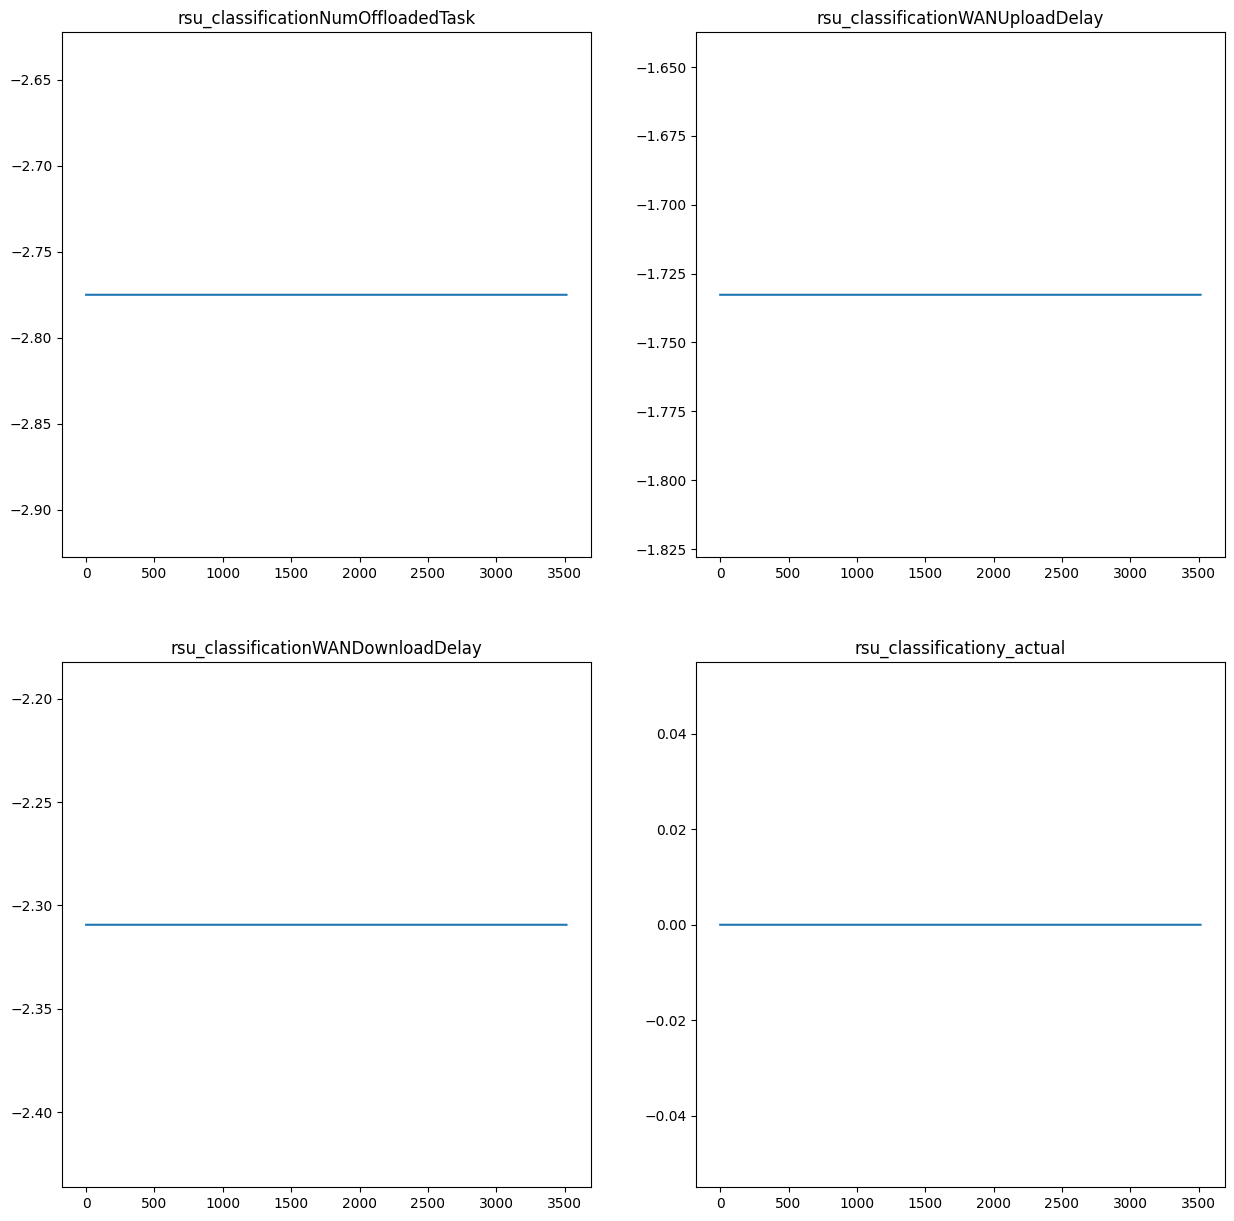

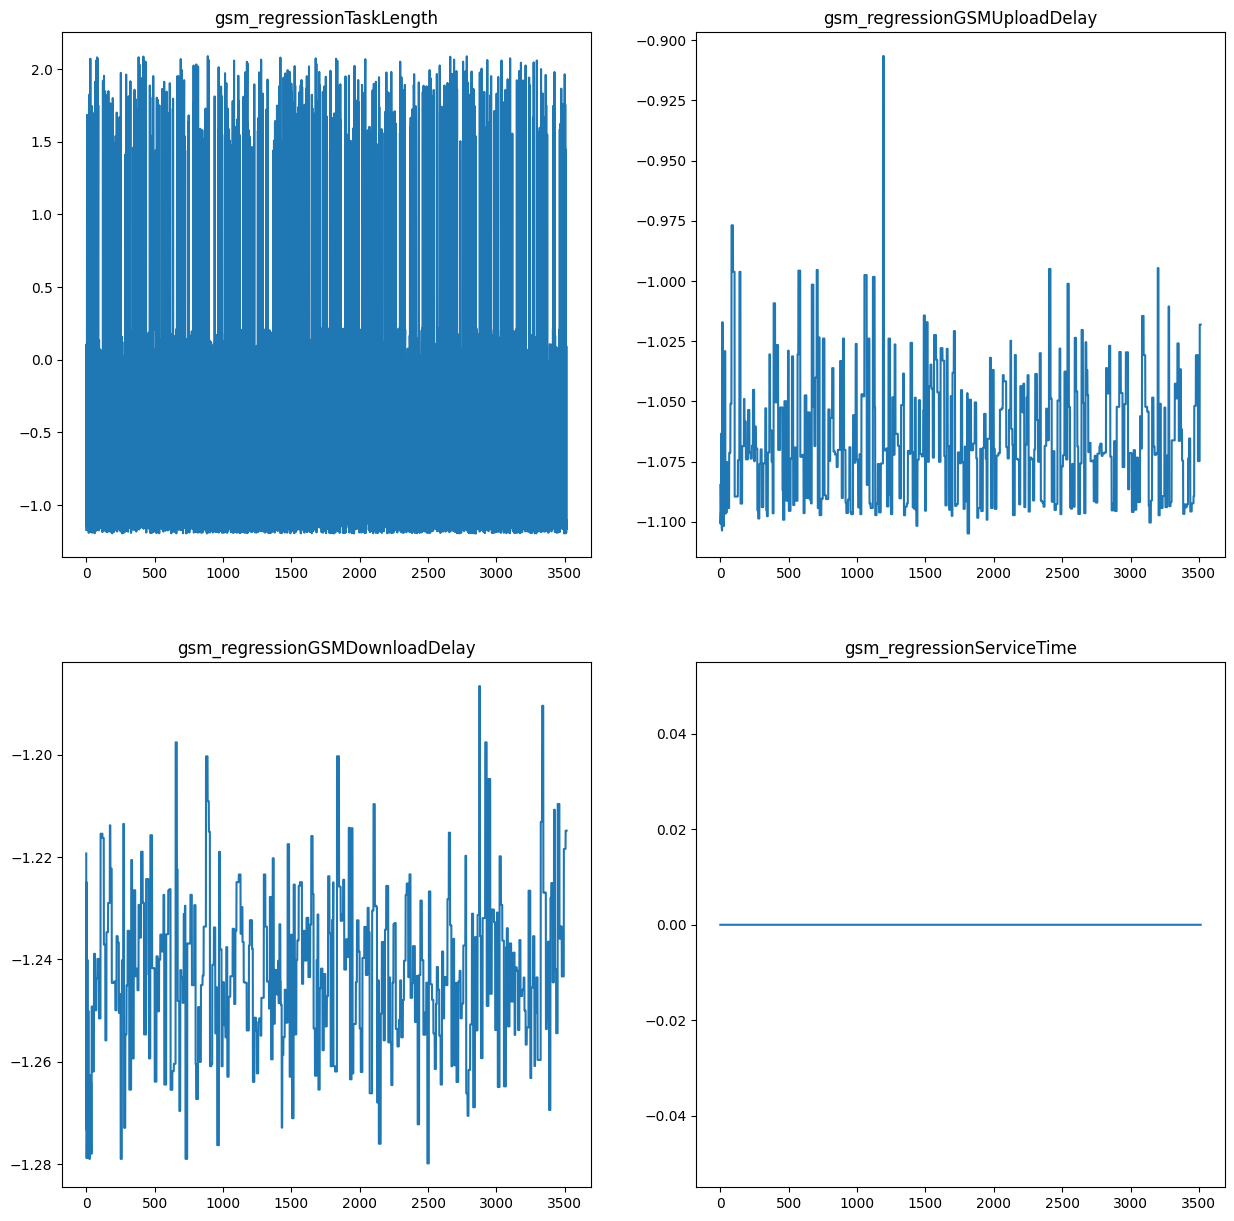

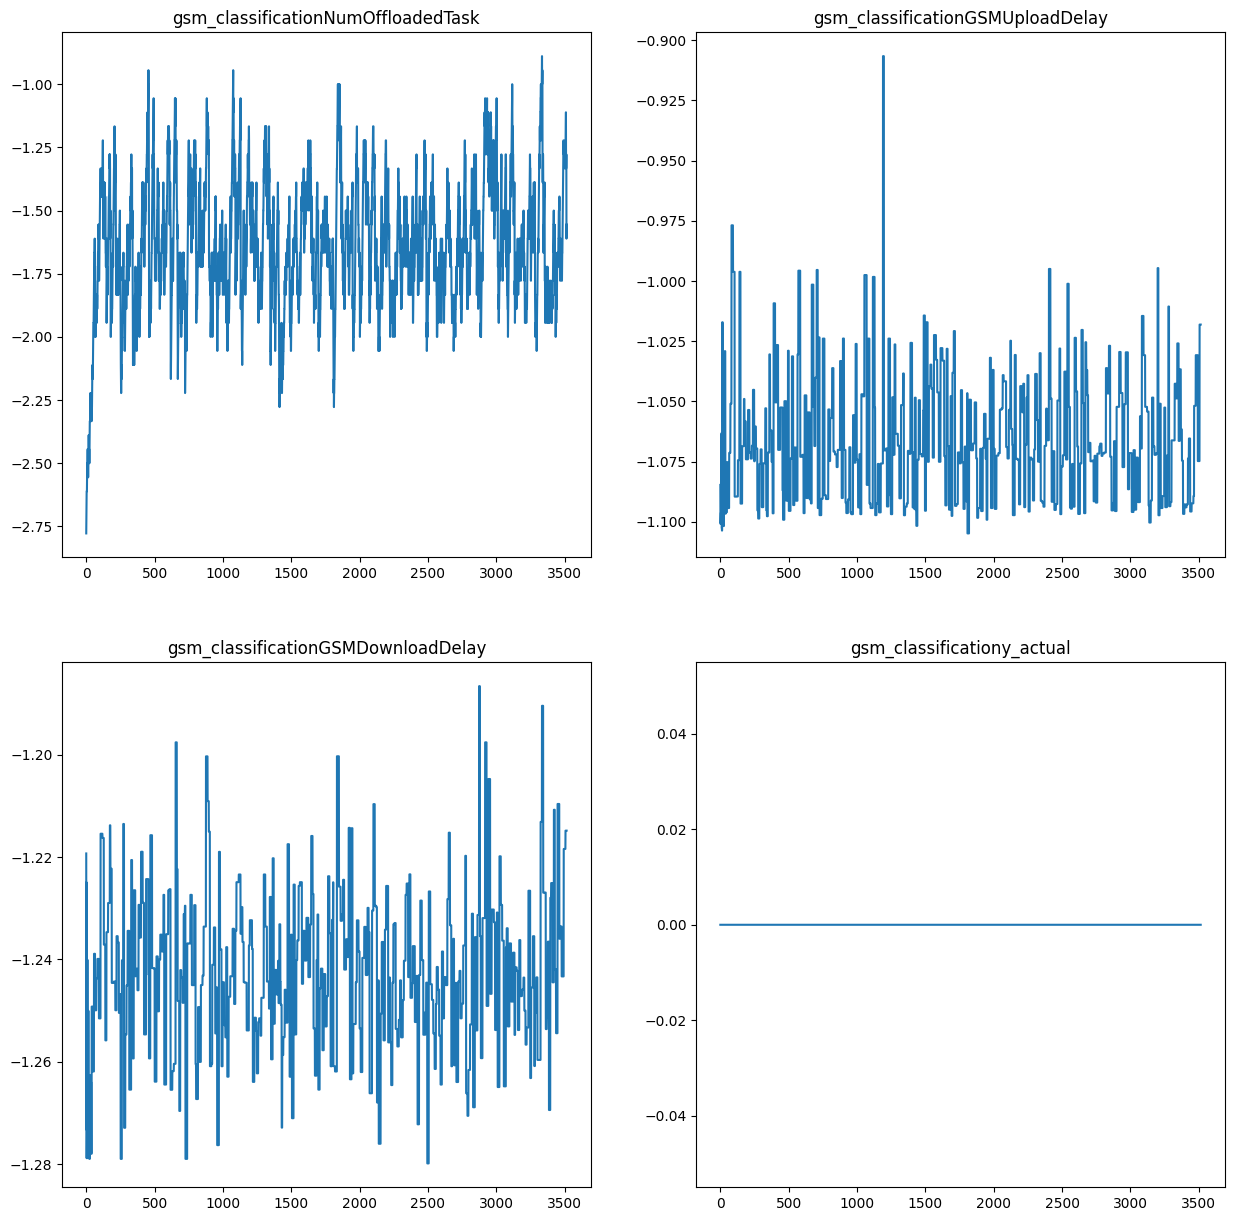

In [3]:
network = ['edge', 'rsu', 'gsm'] 
method = ['regression', 'classification']

for nw in network:
    for m in method:
        
        filepath = PATH + 'Xmatrix_' + nw +  '_' + m + '.txt'
        
        df = pd.read_csv(filepath, sep=",", header=None)
        
        # print('nw: ', nw, 'm: ', m)
        titre = nw+'_'+m
        if nw == 'edge' and m == 'regression':
            df.columns = ["TaskLength","AvgEdgeUtilization","ServiceTime"]
        elif nw == 'edge' and m == 'classification':
            df.columns = ['NumOffloadedTask', "TaskLength","WLANUploadDelay","WLANDownloadDelay","AvgEdgeUtilization", 'y_actual']
        elif nw == 'rsu' and m == 'regression':
            df.columns = ["TaskLength","WANUploadDelay","WANDownloadDelay","ServiceTime"]
        elif nw == 'rsu' and m == 'classification':
            df.columns = ["NumOffloadedTask","WANUploadDelay","WANDownloadDelay", 'y_actual']
        elif nw == 'gsm' and m == 'regression':
            df.columns = ["TaskLength","GSMUploadDelay","GSMDownloadDelay","ServiceTime"]
        elif nw == 'gsm' and m == 'classification':
            df.columns = ["NumOffloadedTask","GSMUploadDelay","GSMDownloadDelay", 'y_actual']
            
        plot_features(df, titre)

# Result

The features that were used by Sonmez et al. are not the same as the features used in Zhu et al. Sonmez et al uses time based features for both classification and regression models; task related features are counts over one senario for loop. The features are ["TaskLength","AvgEdgeUtilization","ServiceTime"] and ['NumOffloadedTask', "TaskLength","WLANUploadDelay","WLANDownloadDelay","AvgEdgeUtilization"] for regression and classification respectively.

## Recoded the SimLogger.java file to output my own features that mimiked the features used in Zhu et al. Stopped using this notebook, and recoded the Q-learning algorithm in java (see DataWrapper.java).